<a href="https://colab.research.google.com/github/Farfaoua01/DL_Project/blob/entrainement_data/projetdl.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import img_to_array, load_img


In [ ]:
data_dir = '/content/drive/MyDrive/deepL/projetDL/Brain_dataset/brain_tumor_dataset'

categories = ['yes', 'no']
print(os.listdir(data_dir))

['yes', 'no']


# Nouvelle section

In [ ]:
categories = os.listdir(data_dir)

for category in categories:
    path = os.path.join(data_dir, category)
    print(f"{category}: {len(os.listdir(path))} images")


yes: 155 images
no: 98 images


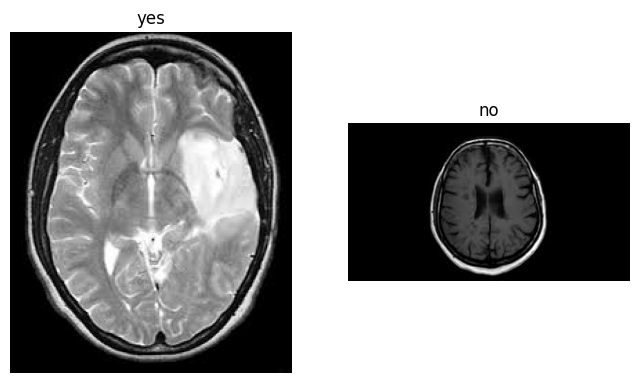

In [ ]:
plt.figure(figsize=(8, 8))
for i, category in enumerate(categories):
    path = os.path.join(data_dir, category)
    img_path = os.path.join(path, os.listdir(path)[0])
    img = load_img(img_path)
    plt.subplot(1, 2, i+1)
    plt.imshow(img)
    plt.title(category)
    plt.axis('off')
plt.show()


In [ ]:
#nettoyage des donnees
corrupted_count = 0

for category in categories:
    path = os.path.join(data_dir, category)
    for img_name in os.listdir(path):
        img_path = os.path.join(path, img_name)
        try:
            img = load_img(img_path)
        except Exception as e:
            print(f"Erreur avec {img_name}: {e}")
            corrupted_count += 1

if corrupted_count == 0:
    print("Toutes les images ont été chargées correctement. Aucun fichier vide ou corrompu trouvé")
else:
    print(f"Nombre d'images corrompues ou illisibles : {corrupted_count}")

Toutes les images ont été chargées correctement. Aucun fichier vide ou corrompu trouvé


{'yes': 155, 'no': 98}


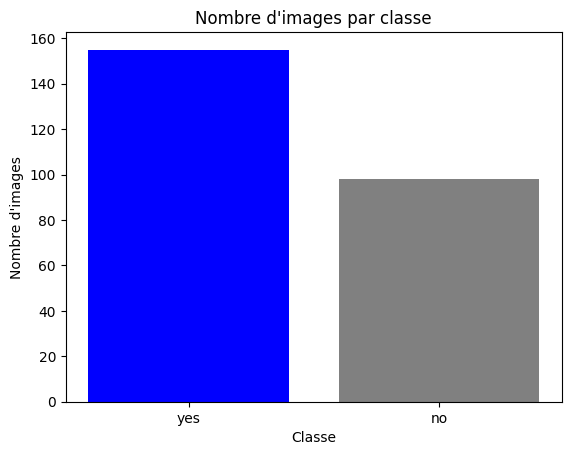

In [ ]:
counts = {}
for category in categories:
    path = os.path.join(data_dir, category)
    counts[category] = len(os.listdir(path))

print(counts)
plt.bar(counts.keys(), counts.values(), color=['blue', 'gray'])
plt.title("Nombre d'images par classe")
plt.xlabel("Classe")
plt.ylabel("Nombre d'images")
plt.show()


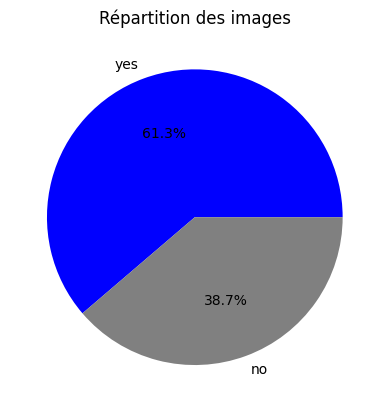

In [ ]:
plt.pie(counts.values(), labels=counts.keys(), autopct='%1.1f%%', colors=['blue', 'gray'])
plt.title("Répartition des images")
plt.show()



In [ ]:
#Augmentation des données pour la classe
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.15,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_gen = datagen.flow_from_directory(
    '/content/drive/MyDrive/deepL/projetDL/Brain_dataset/brain_tumor_dataset',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)


Found 253 images belonging to 2 classes.


In [ ]:
import torch
import torch.nn as nn
from torchvision import models, transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image


In [ ]:
#Définir les transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # même taille que ton ImageDataGenerator
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],  # valeurs standard ImageNet
                         std=[0.229, 0.224, 0.225])
])


In [ ]:
#Créer une classe Dataset personnalisée
class BrainTumorDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.transform = transform
        self.classes = os.listdir(data_dir)
        self.images = []

        for label, category in enumerate(self.classes):
            path = os.path.join(data_dir, category)
            for img_name in os.listdir(path):
                img_path = os.path.join(path, img_name)
                self.images.append((img_path, label))

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path, label = self.images[idx]
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, label


In [ ]:
#Charger les données
from torch.utils.data import random_split

data_dir = '/content/drive/MyDrive/deepL/projetDL/Brain_dataset/brain_tumor_dataset'

dataset = BrainTumorDataset(data_dir, transform=transform)

train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size

train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [ ]:
#Charger le modèle DenseNet pré-entraîné
model = models.densenet121(pretrained=True)
num_classes = 2  # yes / no
model.classifier = nn.Linear(model.classifier.in_features, num_classes)


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth


100%|██████████| 30.8M/30.8M [00:00<00:00, 202MB/s]


In [ ]:
#Définir la perte et l’optimiseur
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)


In [ ]:
# Entraînement du modèle avec validation
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

num_epochs = 20

train_losses = []
val_losses = []
val_accuracies = []

for epoch in range(num_epochs):
    # ---- Phase d'entraînement ----
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)

    # ---- Phase de validation ----
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_loss /= len(test_loader)
    val_acc = 100 * correct / total
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    print(f"Epoch [{epoch+1}/{num_epochs}] - "
          f"Train Loss: {train_loss:.4f} | "
          f"Val Loss: {val_loss:.4f} | "
          f"Val Acc: {val_acc:.2f}%")


Epoch [1/20] - Train Loss: 0.4950 | Val Loss: 0.5247 | Val Acc: 74.51%
Epoch [2/20] - Train Loss: 0.1513 | Val Loss: 0.3288 | Val Acc: 84.31%
Epoch [3/20] - Train Loss: 0.0507 | Val Loss: 0.3385 | Val Acc: 86.27%
Epoch [4/20] - Train Loss: 0.0254 | Val Loss: 0.3575 | Val Acc: 86.27%
Epoch [5/20] - Train Loss: 0.0196 | Val Loss: 0.3322 | Val Acc: 86.27%
Epoch [6/20] - Train Loss: 0.0085 | Val Loss: 0.3259 | Val Acc: 86.27%
Epoch [7/20] - Train Loss: 0.0065 | Val Loss: 0.3197 | Val Acc: 88.24%
Epoch [8/20] - Train Loss: 0.0078 | Val Loss: 0.3142 | Val Acc: 88.24%
Epoch [9/20] - Train Loss: 0.0087 | Val Loss: 0.2920 | Val Acc: 90.20%
Epoch [10/20] - Train Loss: 0.0045 | Val Loss: 0.2948 | Val Acc: 88.24%
Epoch [11/20] - Train Loss: 0.0055 | Val Loss: 0.2930 | Val Acc: 90.20%
Epoch [12/20] - Train Loss: 0.0038 | Val Loss: 0.2998 | Val Acc: 90.20%
Epoch [13/20] - Train Loss: 0.0030 | Val Loss: 0.3091 | Val Acc: 90.20%
Epoch [14/20] - Train Loss: 0.0029 | Val Loss: 0.3180 | Val Acc: 90.20%
E

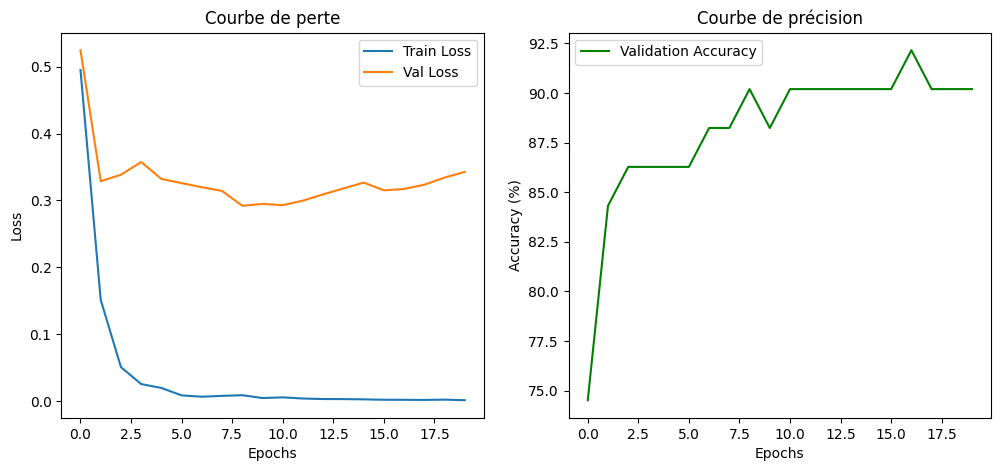

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))

# Courbe des pertes
plt.subplot(1,2,1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Courbe de perte')
plt.legend()

# Courbe d’accuracy
plt.subplot(1,2,2)
plt.plot(val_accuracies, label='Validation Accuracy', color='green')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Courbe de précision')
plt.legend()

plt.show()


In [ ]:
#Sauvegarder modèle
torch.save(model.state_dict(), '/content/drive/MyDrive/deepL/projetDL/model_brain_tumor.pth')


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!cd /content/drive/MyDrive/deepL/projetDL


In [6]:
!git init


hint: Using 'master' as the name for the initial branch. This default branch name
hint: is subject to change. To configure the initial branch name to use in all
hint: of your new repositories, which will suppress this warning, call:
hint: 
hint: 	git config --global init.defaultBranch <name>
hint: 
hint: Names commonly chosen instead of 'master' are 'main', 'trunk' and
hint: 'development'. The just-created branch can be renamed via this command:
hint: 
hint: 	git branch -m <name>
Initialized empty Git repository in /content/.git/


In [8]:
!git add /content/drive/MyDrive/deepL/projetDL/projetdl.ipynb


In [ ]:
!git checkout